In [1]:
from transformers import AutoProcessor, HubertModel, HubertForCTC, Wav2Vec2FeatureExtractor
import torch
import librosa
import numpy as np

In [2]:
neut_audio = "../data/crowd/crowd_test/wavs/d49a6b560155831725a7bdc7d0a96099.wav"
angry_audio = "../data/crowd/crowd_test/wavs/4bd5a9c05848ff92c9a002d92604714f.wav"
sad_audio = "../data/crowd/crowd_test/wavs/95449782aef0f663064737a594824887.wav"
pos_audio = "../data/crowd/crowd_test/wavs/64a7aa17132c3e4b7be1aaed5fc88090.wav"

In [3]:
model_name = "facebook/hubert-base-ls960"
model = HubertModel.from_pretrained(
    model_name,
    output_hidden_states=True
)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

In [4]:
labels = []
i = 0
output_features = []
audio_list = [neut_audio, angry_audio, sad_audio, pos_audio]
sampling_rate = 16000
for audio in audio_list:
    audio_array = librosa.load(
        audio,
        sr=sampling_rate,
        mono=False
    )[0]
    
    input_values = feature_extractor(
        audio_array,
        sampling_rate=sampling_rate,
        return_tensors="pt"
    ).input_values

    output = model(input_values)
    output_features.append(output.last_hidden_state.detach().numpy()[0])
    labels += [i for _ in range(output_features[-1].shape[0])]
    i += 1

data = output_features[0]
for i in range(1, len(output_features)):
    data = np.concatenate((data, output_features[i]))

In [5]:
import simpsom as sps
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

In [6]:
k_means = KMeans(init="k-means++", n_init=15, n_clusters=4)
k_means_labels = k_means.fit_predict(data)
print(adjusted_rand_score(labels, k_means_labels))

0.05294998725991691


2024-09-30 18:46:34.926 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2024-09-30 18:46:34.927 | INFO     | simpsom.network:_set_weights:191 - The weights will be initialized randomly.
2024-09-30 18:46:34.929 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.
2024-09-30 18:46:34.930 | INFO     | simpsom.network:train:396 - Early stop active.
2024-09-30 18:46:34.931 | WARNING  | simpsom.network:train:397 - Early stop is an experimental feature, make sure to know what you are doing!
C:\Study\clustering-methods\venv\Lib\site-packages\simpsom\distances.py:178: RuntimeWarning: invalid value encountered in sqrt
  return self.xp.sqrt(squares_a + squares_b.T - 2 * a.dot(b.T))
2024-09-30 18:46:35.082 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


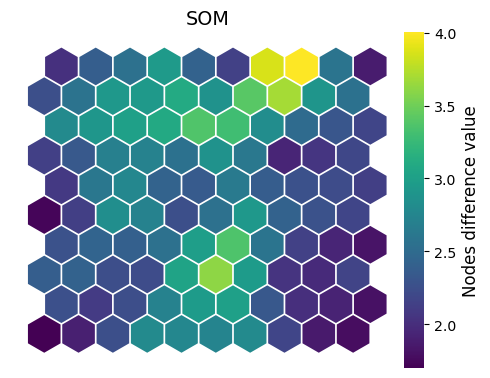

2024-09-30 18:46:35.356 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
./som_projected_KMeans.npy
C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2024-09-30 18:46:35.417 | INFO     | simpsom.network:cluster:678 - Clustering results will be saved to:
././som_clusters.npy


0.039737777266271694


In [7]:
som = sps.SOMNet(10, 10, data, topology='hexagonal',
                 init='random', metric='euclidean',
                 neighborhood_fun='gaussian', PBC=False,
                 random_seed=32, GPU=False, CUML=False,
                 debug=False)

som.train(train_algo='batch', start_learning_rate=0.01, epochs=-1, batch_size=100,
          early_stop="mapdiff", early_stop_tolerance=1e-5)

som.plot_map_by_difference(show=True, print_out=False)

som_labels, _ = som.cluster(data, algorithm='KMeans', n_clusters=4)
print(adjusted_rand_score(labels, som_labels))

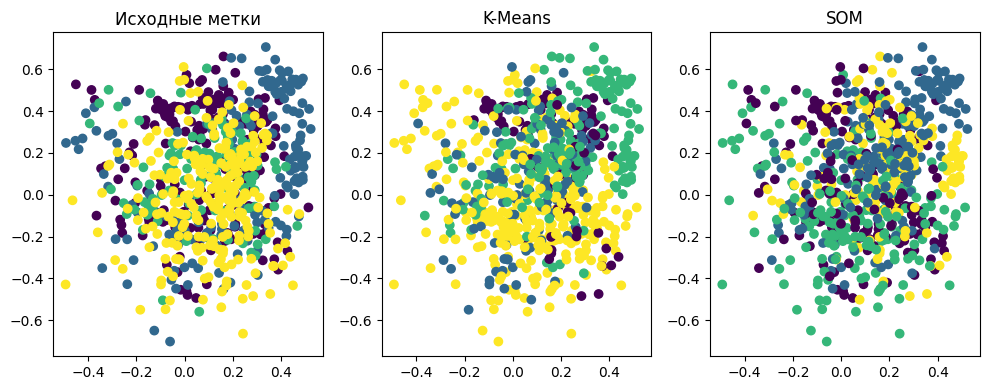

In [8]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(10)

axs[0].scatter(x=data[:, 0], y=data[:, 1], c=labels, cmap='viridis')
axs[0].set_title('Исходные метки')

axs[1].scatter(x=data[:, 0], y=data[:, 1], c=k_means_labels, cmap='viridis')
axs[1].set_title('K-Means')

axs[2].scatter(x=data[:, 0], y=data[:, 1], c=som_labels, cmap='viridis')
axs[2].set_title('SOM')

plt.tight_layout()
plt.show()

In [9]:
pca = PCA(n_components=2)
pca.fit(data)
pca_data = pca.transform(data)

In [10]:
k_means_pca = KMeans(init="k-means++", n_init=15, n_clusters=4)
k_means_pca_labels = k_means_pca.fit_predict(pca_data)
print(adjusted_rand_score(labels, k_means_pca_labels))

0.025269453199649527


2024-09-30 18:46:35.951 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2024-09-30 18:46:35.952 | INFO     | simpsom.network:_set_weights:191 - The weights will be initialized randomly.
2024-09-30 18:46:35.956 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.
2024-09-30 18:46:35.957 | INFO     | simpsom.network:train:396 - Early stop active.
2024-09-30 18:46:35.957 | WARNING  | simpsom.network:train:397 - Early stop is an experimental feature, make sure to know what you are doing!
C:\Study\clustering-methods\venv\Lib\site-packages\simpsom\distances.py:178: RuntimeWarning: invalid value encountered in sqrt
  return self.xp.sqrt(squares_a + squares_b.T - 2 * a.dot(b.T))
2024-09-30 18:46:35.988 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


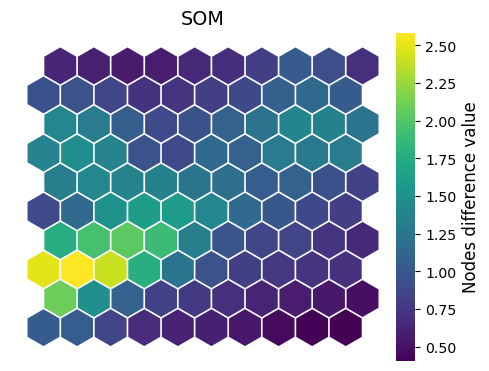

2024-09-30 18:46:36.076 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
./som_projected_KMeans.npy
C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2024-09-30 18:46:36.108 | INFO     | simpsom.network:cluster:678 - Clustering results will be saved to:
././som_clusters.npy


0.014008653291942431


In [11]:
som_pca = sps.SOMNet(10, 10, pca_data, topology='hexagonal',
                 init='random', metric='euclidean',
                 neighborhood_fun='gaussian', PBC=False,
                 random_seed=32, GPU=False, CUML=False,
                 debug=False)

som_pca.train(train_algo='batch', start_learning_rate=0.01, epochs=-1, batch_size=100,
          early_stop="mapdiff", early_stop_tolerance=1e-5)

som_pca.plot_map_by_difference(show=True, print_out=False)

som_pca_labels, _ = som_pca.cluster(pca_data, algorithm='KMeans', n_clusters=4)
print(adjusted_rand_score(labels, som_pca_labels))

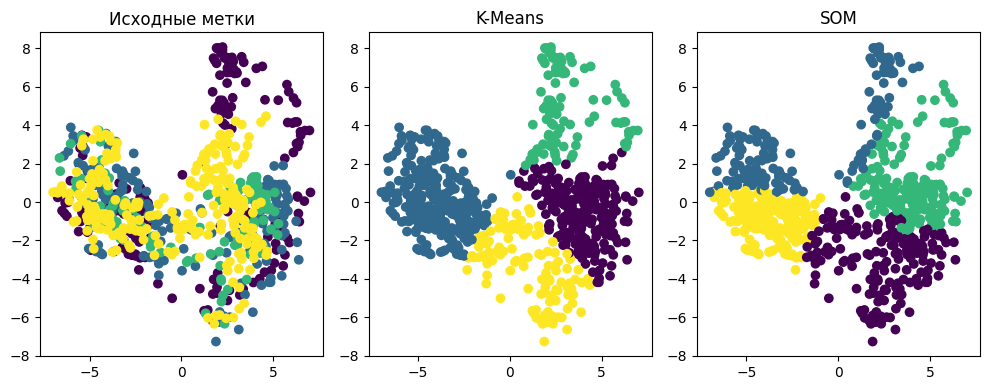

In [12]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(10)

axs[0].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=labels, cmap='viridis')
axs[0].set_title('Исходные метки')

axs[1].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=k_means_pca_labels, cmap='viridis')
axs[1].set_title('K-Means')

axs[2].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=som_pca_labels, cmap='viridis')
axs[2].set_title('SOM')

plt.tight_layout()
plt.show()